In [65]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import r2_score

In [66]:
PLOT_TITLES = ['Exponential', 'Hyperbolic']

FONT_SIZE_1 = 15
FONT_SIZE_2 = 14
FONT_SIZE_3 = 11

In [67]:
original_cmap = sns.diverging_palette(10, 150, as_cmap=True, s=80, l=40)
num_colors = 256
shift_factor = 0.7
num_lower_pos = int(num_colors * shift_factor)
lower_pos = np.linspace(0, 0.5, num_lower_pos)
upper_pos = np.linspace(0.5, 1, num_colors - num_lower_pos)
new_positions = np.concatenate((lower_pos, upper_pos))
COLOR_BAR = LinearSegmentedColormap.from_list("shifted_cmap", original_cmap(new_positions))

In [68]:
import matplotlib
matplotlib.rcParams['font.serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "serif"

In [5]:
def plot_recovery_heatmap(data_list, param_names, model_names, x_label, color_bar_pos, wspace, plot_name):
    fig, axes = plt.subplots(1, 2, figsize=(8, 3), gridspec_kw={'width_ratios': [1, 1], 'wspace': wspace})
    for i, ax in enumerate(axes):
        sns.heatmap(
            data_list[i], annot=True, fmt='.2f', annot_kws={"size": FONT_SIZE_3},
            yticklabels=param_names if i == 0 else [],
            xticklabels=model_names, cmap=COLOR_BAR, ax=ax, vmin=0, vmax=1,
            cbar=False, square=True
        )
        ax.set_title(PLOT_TITLES[i], fontsize=FONT_SIZE_1, pad=10)
        if i == 0:
            ax.set_ylabel('Parameter', fontsize=FONT_SIZE_2)
        else:
            ax.set_ylabel('')
        ax.set_xlabel(x_label, fontsize=FONT_SIZE_2)
        ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
    # Add a single color bar for the entire figure
    cbar_ax = fig.add_axes(color_bar_pos)  # [left, bottom, width, height]
    norm = plt.Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap=COLOR_BAR, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cbar_ax, orientation='vertical')
    # Remove the outline of the color bar
    cbar.outline.set_visible(False)
    # Adjust the font size of the numbers on the color bar
    cbar.ax.tick_params(labelsize=FONT_SIZE_3)

    plt.savefig(
        f'plots/{plot_name}.pdf',
        transparent=True, dpi=600,
        bbox_inches='tight'
    )

## Parameter Recovery 

In [6]:
param_names = [r'Threshold ($\theta$)', r'Decay ($\lambda$)']
model_names = ['No Constraint', 'NDT Constraint']
x_label = 'Model'
color_bar_pos = [0.84, 0.1, 0.02, 0.78]
wspace = -0.3

### IE

In [7]:
no_constraint_exp_recovery = pd.read_csv('_01_IE/_01_no_constrain/_data/Exponential_rec_500.csv', index_col=0).to_numpy()
no_constraint_hyper_recovery = pd.read_csv('_01_IE/_01_no_constrain/_data/Hyperbolic_rec_500.csv', index_col=0).to_numpy()
ndt_constraint_exp_recovery = pd.read_csv('_01_IE/_02_ndt_constrain/_data/Exponential_rec_500.csv', index_col=0).to_numpy()
ndt_constraint_hyper_recovery = pd.read_csv('_01_IE/_02_ndt_constrain/_data/Hyperbolic_rec_500.csv', index_col=0).to_numpy()
recovery_data = [
    no_constraint_exp_recovery, no_constraint_hyper_recovery,
    ndt_constraint_exp_recovery, ndt_constraint_hyper_recovery
]
r2_exp = np.array([
    [
        r2_score(no_constraint_exp_recovery[:, 0], no_constraint_exp_recovery[:, 1]),
        r2_score(ndt_constraint_exp_recovery[:, 0], ndt_constraint_exp_recovery[:, 1]),
    ],
    [
        r2_score(no_constraint_exp_recovery[:, 2], no_constraint_exp_recovery[:, 3]),
        r2_score(ndt_constraint_exp_recovery[:, 2], ndt_constraint_exp_recovery[:, 3]),
    ],
])
r2_hyper = np.array([
    [
        r2_score(no_constraint_hyper_recovery[:, 0], no_constraint_hyper_recovery[:, 1]),
        r2_score(ndt_constraint_hyper_recovery[:, 0], ndt_constraint_hyper_recovery[:, 1]),
    ],
    [
        r2_score(no_constraint_hyper_recovery[:, 2], no_constraint_hyper_recovery[:, 3]),
        r2_score(ndt_constraint_hyper_recovery[:, 2], ndt_constraint_hyper_recovery[:, 3]),
    ],
])

data_list = [r2_exp, r2_hyper]

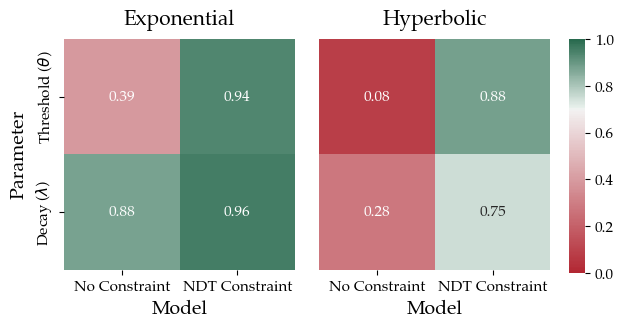

In [8]:
plot_recovery_heatmap(
    data_list, param_names, model_names, x_label, color_bar_pos, wspace, 'IE_parameter_recovery'
)

### BF

In [9]:
with open('_02_BF/data/BF_recovery_r2_scores.pkl', 'rb') as f:
    r2_scores_dict = pickle.load(f)

In [10]:
data_hyperbolic = np.array([
    [values[1], values[2]] for key, values in r2_scores_dict.items() if 'hyperbolic' in key
])
data_exponential = np.array([
    [values[1], values[2]] for key, values in r2_scores_dict.items() if 'exponential' in key
])
data_hyperbolic = data_hyperbolic.T
data_exponential = data_exponential.T
data_list = [data_exponential, data_hyperbolic]

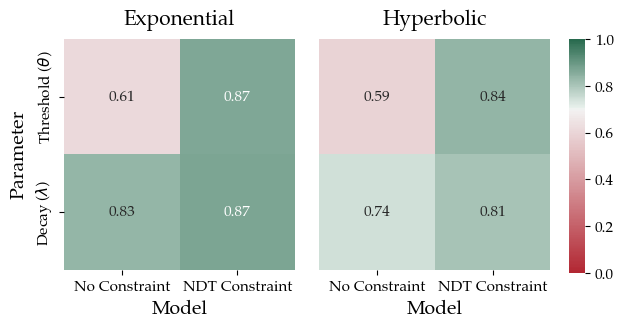

In [11]:
plot_recovery_heatmap(
    data_list, param_names, model_names, x_label, color_bar_pos, wspace, 'BF_parameter_recovery'
)

## Sensitivity to Noise

In [63]:
param_names = [
    r'Threshold ($\theta$)', r'Decay ($\lambda$)',
    r'NDT ($\tau$)', r'Drift rate ($v$)'
]
param_names_2 = [
    r'Threshold ($\theta$)', r'Decay ($\lambda$)',
    r'NDT ($\tau$)', r'Drift rate ($v$)', r'Observation noise ($\sigma$)'
]
model_names = [
    r'$\sigma_z = 0.3$', 
    r'$\sigma_z = 0.6$', r'$\sigma_z = 0.9$',
    'No constraint'
]
x_label = 'Model'
color_bar_pos = [0.9, 0.11, 0.02, 0.77]
wspace = 0.0

### IE

In [14]:
exp_03_recovery = pd.read_csv('_01_IE/_03_ndt_constrain_fixed_sigma/_data/Exponential_rec_sig03.csv', index_col=0).to_numpy()
exp_06_recovery = pd.read_csv('_01_IE/_03_ndt_constrain_fixed_sigma/_data/Exponential_rec_sig06.csv', index_col=0).to_numpy()
exp_09_recovery = pd.read_csv('_01_IE/_03_ndt_constrain_fixed_sigma/_data/Exponential_rec_sig09.csv', index_col=0).to_numpy()
no_constraint_exp_recovery = pd.read_csv('_01_IE/_01_no_constrain/_data/Exponential_rec_500.csv', index_col=0).to_numpy()
no_constraint_hyper_recovery = pd.read_csv('_01_IE/_01_no_constrain/_data/Hyperbolic_rec_500.csv', index_col=0).to_numpy()
hyper_03_recovery = pd.read_csv('_01_IE/_03_ndt_constrain_fixed_sigma/_data/Hyperbolic_rec_sig03.csv', index_col=0).to_numpy()
hyper_06_recovery = pd.read_csv('_01_IE/_03_ndt_constrain_fixed_sigma/_data/Hyperbolic_rec_sig06.csv', index_col=0).to_numpy()
hyper_09_recovery = pd.read_csv('_01_IE/_03_ndt_constrain_fixed_sigma/_data/Hyperbolic_rec_sig09.csv', index_col=0).to_numpy()

r2_exp = np.array([
    [
        r2_score(exp_03_recovery[:, 0], exp_03_recovery[:, 1]),
        r2_score(exp_06_recovery[:, 0], exp_06_recovery[:, 1]),
        r2_score(exp_09_recovery[:, 0], exp_09_recovery[:, 1]),
        r2_score(no_constraint_exp_recovery[:, 0], no_constraint_exp_recovery[:, 1]),
    ],
    [
        r2_score(exp_03_recovery[:, 2], exp_03_recovery[:, 3]),
        r2_score(exp_06_recovery[:, 2], exp_06_recovery[:, 3]),
        r2_score(exp_09_recovery[:, 2], exp_09_recovery[:, 3]),
        r2_score(no_constraint_exp_recovery[:, 2], no_constraint_exp_recovery[:, 3]),
    ],
    [
        r2_score(exp_03_recovery[:, -2], exp_03_recovery[:, -1]),
        r2_score(exp_06_recovery[:, -2], exp_06_recovery[:, -1]),
        r2_score(exp_09_recovery[:, -2], exp_09_recovery[:, -1]),
        r2_score(no_constraint_exp_recovery[:, -2], no_constraint_exp_recovery[:, -1]),
    ],
    [
        r2_score(exp_03_recovery[:, 4], exp_03_recovery[:, 5]),
        r2_score(exp_06_recovery[:, 4], exp_06_recovery[:, 5]),
        r2_score(exp_09_recovery[:, 4], exp_09_recovery[:, 5]),
        r2_score(no_constraint_exp_recovery[:, 4], no_constraint_exp_recovery[:, 5]),
    ]
])
r2_hyper = np.array([
    [
        r2_score(hyper_03_recovery[:, 0], hyper_03_recovery[:, 1]),
        r2_score(hyper_06_recovery[:, 0], hyper_06_recovery[:, 1]),
        r2_score(hyper_09_recovery[:, 0], hyper_09_recovery[:, 1]),
        r2_score(no_constraint_hyper_recovery[:, 0], no_constraint_hyper_recovery[:, 1]),
    ],
    [
        r2_score(hyper_03_recovery[:, 2], hyper_03_recovery[:, 3]),
        r2_score(hyper_06_recovery[:, 2], hyper_06_recovery[:, 3]),
        r2_score(hyper_09_recovery[:, 2], hyper_09_recovery[:, 3]),
        r2_score(no_constraint_hyper_recovery[:, 2], no_constraint_hyper_recovery[:, 3]),
    ],
    [
        r2_score(hyper_03_recovery[:, -2], hyper_03_recovery[:, -1]),
        r2_score(hyper_06_recovery[:, -2], hyper_06_recovery[:, -1]),
        r2_score(hyper_09_recovery[:, -2], hyper_09_recovery[:, -1]),
        r2_score(no_constraint_hyper_recovery[:, -2], no_constraint_hyper_recovery[:, -1]),
    ],
    [
        r2_score(hyper_03_recovery[:, 4], hyper_03_recovery[:, 5]),
        r2_score(hyper_06_recovery[:, 4], hyper_06_recovery[:, 5]),
        r2_score(hyper_09_recovery[:, 4], hyper_09_recovery[:, 5]),
        r2_score(no_constraint_hyper_recovery[:, 4], no_constraint_hyper_recovery[:, 5]),
    ]
])

data_list = [r2_exp, r2_hyper]


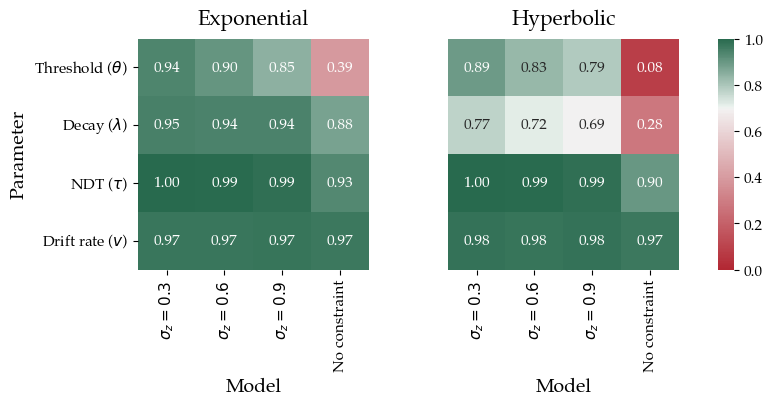

In [15]:
plot_recovery_heatmap(
    data_list, param_names, model_names, x_label, color_bar_pos, wspace, 'IE_noise_sensitivity'
)

### BF

In [16]:
with open('_02_BF/data/BF_noise_sensitivity_r2_scores.pkl', 'rb') as f:
    r2_scores_dict = pickle.load(f)

In [17]:
data_hyperbolic = np.array([
    [values[1], values[2], values[3], values[0]] for key, values in r2_scores_dict.items() if 'hyperbolic' in key
])
data_exponential = np.array([
    [values[1], values[2], values[3], values[0]] for key, values in r2_scores_dict.items() if 'exponential' in key
])
data_hyperbolic = data_hyperbolic.T
data_hyperbolic = data_hyperbolic[:, [1, 2, 3, 0]]
data_exponential = data_exponential.T
data_exponential = data_exponential[:, [1, 2, 3, 0]]
data_list = [data_exponential, data_hyperbolic]

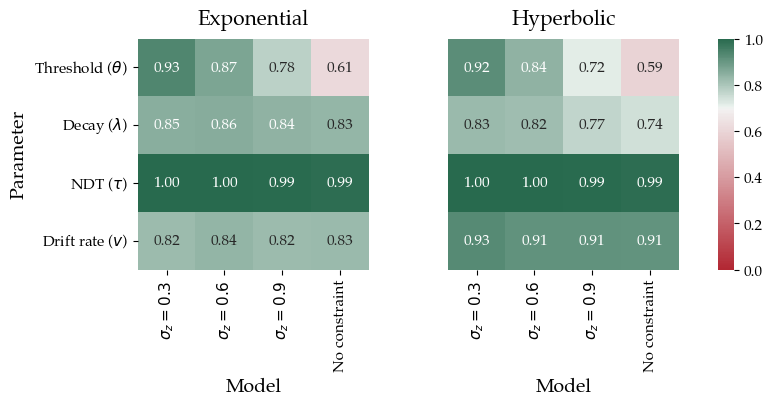

In [18]:
plot_recovery_heatmap(
    data_list, param_names, model_names, x_label, color_bar_pos, wspace, 'BF_noise_sensitivity'
)

## Sensitivity to Number of Observations

In [19]:
param_names = [
    r'Threshold ($\theta$)', r'Decay ($\lambda$)',
    r'NDT ($\tau$)', r'Drift rate ($v$)'
]
model_names = [
    r'$N = 100$', r'$N = 250$', r'$N = 500$', r'$N = 1000$'
]
x_label = 'Number of observations'
color_bar_pos = [0.9, 0.11, 0.02, 0.77]
wspace = 0.0

### IF

In [27]:
exp_100_recovery = pd.read_csv('_01_IE/_02_ndt_constrain/_data/Exponential_rec_100.csv', index_col=0).to_numpy()
exp_250_recovery = pd.read_csv('_01_IE/_02_ndt_constrain/_data/Exponential_rec_250.csv', index_col=0).to_numpy()
exp_500_recovery = pd.read_csv('_01_IE/_02_ndt_constrain/_data/Exponential_rec_500.csv', index_col=0).to_numpy()
exp_1000_recovery = pd.read_csv('_01_IE/_02_ndt_constrain/_data/Exponential_rec_1000.csv', index_col=0).to_numpy()
hyper_100_recovery = pd.read_csv('_01_IE/_02_ndt_constrain/_data/Hyperbolic_rec_100.csv', index_col=0).to_numpy()
hyper_250_recovery = pd.read_csv('_01_IE/_02_ndt_constrain/_data/Hyperbolic_rec_250.csv', index_col=0).to_numpy()
hyper_500_recovery = pd.read_csv('_01_IE/_02_ndt_constrain/_data/Hyperbolic_rec_500.csv', index_col=0).to_numpy()
hyper_1000_recovery = pd.read_csv('_01_IE/_02_ndt_constrain/_data/Hyperbolic_rec_1000.csv', index_col=0).to_numpy()

r2_exp = np.array([
    [
        r2_score(exp_100_recovery[:, 0], exp_100_recovery[:, 1]),
        r2_score(exp_250_recovery[:, 0], exp_250_recovery[:, 1]),
        r2_score(exp_500_recovery[:, 0], exp_500_recovery[:, 1]),
        r2_score(exp_1000_recovery[:, 0], exp_1000_recovery[:, 1]),
    ],
    [
        r2_score(exp_100_recovery[:, 2], exp_100_recovery[:, 3]),
        r2_score(exp_250_recovery[:, 2], exp_250_recovery[:, 3]),
        r2_score(exp_500_recovery[:, 2], exp_500_recovery[:, 3]),
        r2_score(exp_1000_recovery[:, 2], exp_1000_recovery[:, 3]),
    ],
    [
        r2_score(exp_100_recovery[:, -2], exp_100_recovery[:, -1]),
        r2_score(exp_250_recovery[:, -2], exp_250_recovery[:, -1]),
        r2_score(exp_500_recovery[:, -2], exp_500_recovery[:, -1]),
        r2_score(exp_1000_recovery[:, -2], exp_1000_recovery[:, -1]),
    ],
    [
        r2_score(exp_100_recovery[:, 4], exp_100_recovery[:, 5]),
        r2_score(exp_250_recovery[:, 4], exp_250_recovery[:, 5]),
        r2_score(exp_500_recovery[:, 4], exp_500_recovery[:, 5]),
        r2_score(exp_1000_recovery[:, 4], exp_1000_recovery[:, 5]),
    ]
])
r2_hyper = np.array([
    [
        r2_score(hyper_100_recovery[:, 0], hyper_100_recovery[:, 1]),
        r2_score(hyper_250_recovery[:, 0], hyper_250_recovery[:, 1]),
        r2_score(hyper_500_recovery[:, 0], hyper_500_recovery[:, 1]),
        r2_score(hyper_1000_recovery[:, 0], hyper_1000_recovery[:, 1]),
    ],
    [
        r2_score(hyper_100_recovery[:, 2], hyper_100_recovery[:, 3]),
        r2_score(hyper_250_recovery[:, 2], hyper_250_recovery[:, 3]),
        r2_score(hyper_500_recovery[:, 2], hyper_500_recovery[:, 3]),
        r2_score(hyper_1000_recovery[:, 2], hyper_1000_recovery[:, 3]),
    ],
    [
        r2_score(hyper_100_recovery[:, -2], hyper_100_recovery[:, -1]),
        r2_score(hyper_250_recovery[:, -2], hyper_250_recovery[:, -1]),
        r2_score(hyper_500_recovery[:, -2], hyper_500_recovery[:, -1]),
        r2_score(hyper_1000_recovery[:, -2], hyper_1000_recovery[:, -1]),
    ],
    [
        r2_score(hyper_100_recovery[:, 4], hyper_100_recovery[:, 5]),
        r2_score(hyper_250_recovery[:, 4], hyper_250_recovery[:, 5]),
        r2_score(hyper_500_recovery[:, 4], hyper_500_recovery[:, 5]),
        r2_score(hyper_1000_recovery[:, 4], hyper_1000_recovery[:, 5]),
    ]
])

data_list = [r2_exp, r2_hyper]

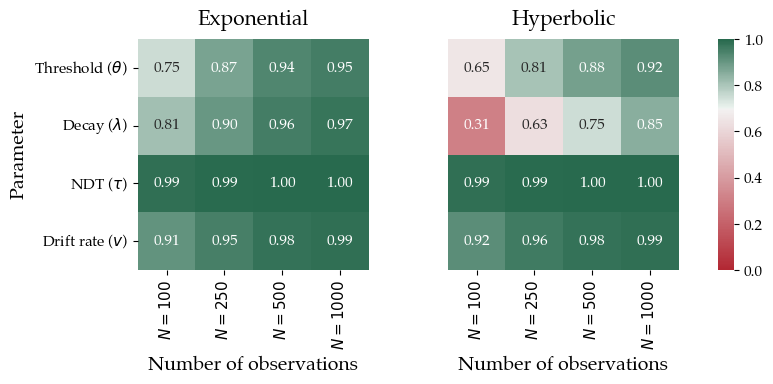

In [28]:
plot_recovery_heatmap(
    data_list, param_names, model_names, x_label, color_bar_pos, wspace, 'IE_num_obs_sensitivity'
)

### BF

In [20]:
with open('_02_BF/data/BF_num_obs_sensitivity_r2_scores.pkl', 'rb') as f:
    r2_scores_dict = pickle.load(f)

In [21]:
data_hyperbolic = np.array([
    [values[1], values[2], values[3], values[0]] for key, values in r2_scores_dict.items() if 'hyperbolic' in key
])
data_exponential = np.array([
    [values[1], values[2], values[3], values[0]] for key, values in r2_scores_dict.items() if 'exponential' in key
])
data_hyperbolic = data_hyperbolic.T
data_exponential = data_exponential.T
data_list = [data_exponential, data_hyperbolic]

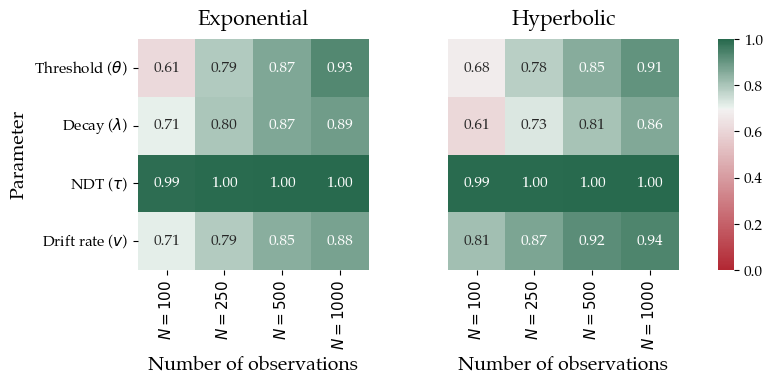

In [22]:
plot_recovery_heatmap(
    data_list, param_names, model_names, x_label, color_bar_pos, wspace, 'BF_num_obs_sensitivity'
)

## Traditional Recovery Plot

In [151]:
hyp_df = pd.read_csv('_01_IE/_02_ndt_constrain/_data/Hyperbolic_rec_500.csv')
exp_df = pd.read_csv('_01_IE/_02_ndt_constrain/_data/Exponential_rec_500.csv')

cols = list(exp_df.columns)
sigma_cols = ['delta_true', 'delta_estimate', 'sigma_true', 'sigma_estimate']
new_order = [col for col in cols if col not in sigma_cols] + sigma_cols
hyp_df = hyp_df[new_order[1:]].to_numpy()
even = hyp_df[:, 0::2]
odd = hyp_df[:, 1::2]
hyperbolic_constraint = np.stack((even, odd), axis=-1)
exp_df = exp_df[new_order[1:]].to_numpy()
even = exp_df[:, 0::2]
odd = exp_df[:, 1::2]
exponential_constraint = np.stack((even, odd), axis=-1)
constraint_recovery = [exponential_constraint, hyperbolic_constraint]


bhyp_df = pd.read_csv('_01_IE/_01_no_constrain/_data/Hyperbolic_rec_500.csv')
bexp_df = pd.read_csv('_01_IE/_01_no_constrain/_data/Exponential_rec_500.csv')
cols = list(bexp_df.columns)
sigma_cols = ['delta_true', 'delta_estimate']
new_order = [col for col in cols if col not in sigma_cols] + sigma_cols

bhyp_df = bhyp_df[new_order[1:]].to_numpy()
bexp_df = bexp_df[new_order[1:]].to_numpy()
even = bhyp_df[:, 0::2]
odd = bhyp_df[:, 1::2]
hyperbolic_no_constraint = np.stack((even, odd), axis=-1)
even = bexp_df[:, 0::2]
odd = bexp_df[:, 1::2]
exponential_no_constraint = np.stack((even, odd), axis=-1)
no_constraint_recovery = [exponential_no_constraint, hyperbolic_no_constraint]

In [152]:
param_names = [
    r'Threshold ($\theta$)', r'Decay ($\lambda$)',
    r'NDT ($\tau$)', r'Drift rate ($v$)', r'Observation noise ($\sigma$)'
]

In [153]:
FONT_SIZE_1 = 15
FONT_SIZE_2 = 12
FONT_SIZE_3 = 8

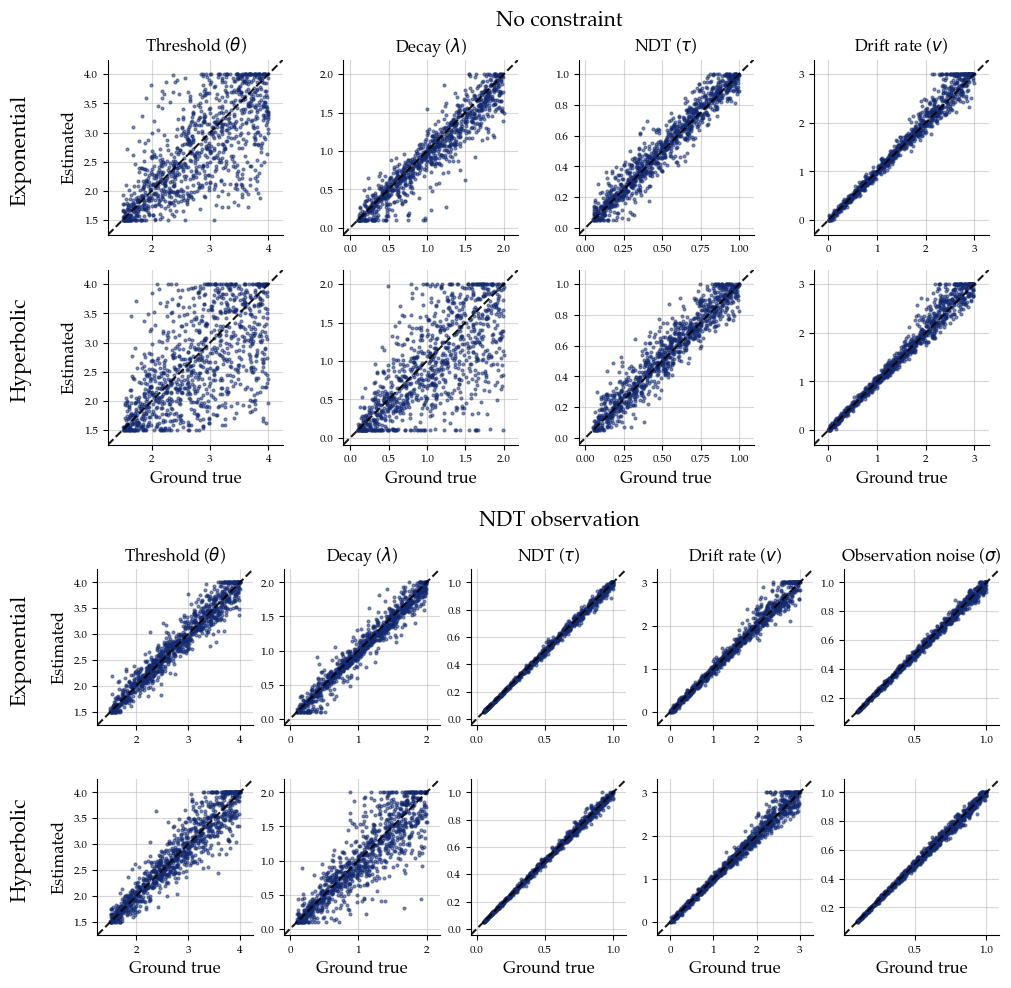

In [161]:
fig = plt.figure(figsize=(11, 10))
subfigs = fig.subfigures(2, 1, height_ratios=[4, 4])

### --- No constraint ---
axs1 = subfigs[0].subplots(2, 4)
subfigs[0].suptitle('No constraint', fontsize=FONT_SIZE_1)

for i in range(2):
    for j in range(4):
        axs1[i, j].plot(
            no_constraint_recovery[i][:, j, 0],
            no_constraint_recovery[i][:, j, 1],
            'o', markersize=2, color="#132a70", alpha=0.5
        )
        if i == 0:
            axs1[i, j].set_title(param_names[j], fontsize=FONT_SIZE_2)
        if j == 0:
            axs1[i, j].set_ylabel("Estimated", fontsize=FONT_SIZE_2)
        if i == 1:
            axs1[i, j].set_xlabel("Ground true", fontsize=FONT_SIZE_2)
        axs1[i, j].tick_params(labelsize=FONT_SIZE_3)

        lower = min(no_constraint_recovery[i][:, j, 0].min(), no_constraint_recovery[i][:, j, 1].min())
        upper = max(no_constraint_recovery[i][:, j, 0].max(), no_constraint_recovery[i][:, j, 1].max())
        eps = (upper - lower) * 0.1
        axs1[i, j].set_xlim((lower - eps, upper + eps))
        axs1[i, j].set_ylim((lower - eps, upper + eps))
        axs1[i, j].plot(
            [axs1[i, j].get_xlim()[0], axs1[i, j].get_xlim()[1]],
            [axs1[i, j].get_ylim()[0], axs1[i, j].get_ylim()[1]],
            color="black",
            alpha=0.9,
            linestyle="dashed",
        )
        axs1[i, j].grid(alpha=0.5)
        axs1[i, j].set_aspect('equal', adjustable='box')

### --- NDT observation ---
axs2 = subfigs[1].subplots(2, 5)
subfigs[1].suptitle('NDT observation', fontsize=FONT_SIZE_1)

for i in range(2):
    for j in range(5):
        axs2[i, j].plot(
            constraint_recovery[i][:, j, 0],
            constraint_recovery[i][:, j, 1],
            'o', markersize=2, color="#132a70", alpha=0.5
        )
        if i == 0:
            axs2[i, j].set_title(param_names[j], fontsize=FONT_SIZE_2)
        if j == 0:
            axs2[i, j].set_ylabel("Estimated", fontsize=FONT_SIZE_2)
        if i == 1:
            axs2[i, j].set_xlabel("Ground true", fontsize=FONT_SIZE_2)
        axs2[i, j].tick_params(labelsize=FONT_SIZE_3)

        lower = min(constraint_recovery[i][:, j, 0].min(), constraint_recovery[i][:, j, 1].min())
        upper = max(constraint_recovery[i][:, j, 0].max(), constraint_recovery[i][:, j, 1].max())
        eps = (upper - lower) * 0.1
        axs2[i, j].set_xlim((lower - eps, upper + eps))
        axs2[i, j].set_ylim((lower - eps, upper + eps))
        axs2[i, j].plot(
            [axs2[i, j].get_xlim()[0], axs2[i, j].get_xlim()[1]],
            [axs2[i, j].get_ylim()[0], axs2[i, j].get_ylim()[1]],
            color="black",
            alpha=0.9,
            linestyle="dashed",
        )
        axs2[i, j].grid(alpha=0.5)
        axs2[i, j].set_aspect('equal', adjustable='box')

# Better-aligned row labels for top subfigure
subfigs[0].text(0.02, 0.7, 'Exponential', va='center', ha='right', rotation='vertical',fontsize=FONT_SIZE_1)
subfigs[0].text(0.02, 0.3, 'Hyperbolic', va='center', ha='right', rotation='vertical', fontsize=FONT_SIZE_1)
subfigs[1].text(0.02, 0.7, 'Exponential', va='center', ha='right', rotation='vertical', fontsize=FONT_SIZE_1)
subfigs[1].text(0.02, 0.3, 'Hyperbolic', va='center', ha='right', rotation='vertical', fontsize=FONT_SIZE_1)

sns.despine()
fig.subplots_adjust(left=0.08) 

plt.savefig(
    f'plots/IE_traditional_recovery_plot.pdf',
    transparent=True, dpi=600,
    bbox_inches='tight'
)